In [1]:
import os 
os.environ['http_proxy']="http://172.17.0.1:7890"
os.environ['https_proxy']="http://172.17.0.1:7890"
os.environ['all_proxy']="http://172.17.0.1:7890"
import foolbox as fb
import numpy as np
import cv2
import torch
import torchvision
from pytorchcv.model_provider import get_model as ptcv_get_model
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import copy
from sklearn.decomposition import PCA
pca = PCA(n_components=10, whiten=True)

In [2]:
#imageNet model loading...
model = ptcv_get_model('resnet101',pretrained=True)
model = model.eval()
preprocessing = dict(axis=-3)
fmodel = fb.PyTorchModel(model,bounds=(0,1),preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((0,1))
#imageNet adversarial examples loading...
img_adv = torch.load("./advImageNet-Data-DF2.pkl")
img_labs = torch.load("./advImageNet-labels-DF2.pkl")
# fb.accuracy(fmodel,img_adv[1000:2000],img_labs[1000:2000])

In [74]:
from torch import nn
import torch.nn.functional as F
#import Mnist model define
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
#import model
model = ptcv_get_model('resnet110_cifar10',pretrained=True)
model= model.eval()
#load attacked data
cifar_adv = torch.load("./advsamples/advCifarData-3-L2-DeepFool.pkl")
cifar_labs = torch.load("./advsamples/advCifarLabel-3-L2-DeepFool.pkl")
mnist_model = torch.load("./pyMNIST_model")
mnist_adv = torch.load("./advMnistData-testLoader-3-L2FGSM.pkl")
mnist_labs = torch.load("./advMnistLabel-testLoader-3-L2FGSM.pkl")
mnist_model=mnist_model.eval()

In [75]:
model = mnist_model.eval()
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print(size_all_mb)

0.08270263671875


In [3]:
img_adv.shape

torch.Size([2440, 3, 224, 224])

In [4]:
#CIFAR_Processing
preprocessing = dict(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201], axis=-3)
fmodel = fb.PyTorchModel(model,bounds=(0,1))
#MNIST_Processing
# preprocessing = dict(mean=[0.1307], std=[0.3081], axis=-3)

# fmodel = fb.PyTorchModel(mnist_model,bounds=(0,1))

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fb.accuracy(fmodel,cifar_adv,cifar_labs)
# fb.accuracy(fmodel,mnist_adv,mnist_labs)

0.001479289960116148

In [42]:
def get_fade_mask(num,lim):
#     x_b = np.ones((32,32)) #Cifar10 
#     x_b = np.ones((28,28)) #Mnist
    x_b = np.ones((224,224)) #ImgNet

    for i in range(num):
        x_axis = np.random.randint(1, 222)
        y_axis = np.random.randint(1, 222)
        case_radom = np.random.randint(1, 7)
        
        backsplash_2x2=1
        splash_2x2=2
        star_3x3=3
        cross_3x3=4
        star_5x5=5
        circle_5x5 = 6
        if (case_radom == star_3x3) :
            x_b[x_axis-1][y_axis-1] = lim
            x_b[x_axis-1][y_axis+1] = lim
            x_b[x_axis][y_axis] = lim
            x_b[x_axis+1][y_axis-1] = lim
            x_b[x_axis+1][y_axis+1] = lim
        
        elif (case_radom == splash_2x2) :
            x_b[x_axis][y_axis] = lim
            x_b[x_axis+1][y_axis+1] = lim
        
        elif (case_radom == backsplash_2x2) :
            x_b[x_axis][y_axis+1] = lim
            x_b[x_axis+1][y_axis] = lim
        
        elif (case_radom == cross_3x3) :
            x_b[x_axis-1][y_axis] = lim
            x_b[x_axis][y_axis+1] = lim
            x_b[x_axis][y_axis] = lim
            x_b[x_axis][y_axis-1] = lim
            x_b[x_axis+1][y_axis] = lim
            
        elif (case_radom == star_5x5) :
            x_b[x_axis-2][y_axis+2] = lim
            x_b[x_axis-1][y_axis+1] = lim
            x_b[x_axis-2][y_axis-2] = lim
            x_b[x_axis-1][y_axis-1] = lim
            x_b[x_axis][y_axis-2] = lim
            x_b[x_axis][y_axis-1] = lim
            x_b[x_axis][y_axis] = lim
            x_b[x_axis][y_axis+1] = lim
            x_b[x_axis][y_axis+2] = lim
            x_b[x_axis+1][y_axis+1] = lim
            x_b[x_axis+2][y_axis+2] = lim
            x_b[x_axis+1][y_axis-1] = lim
            x_b[x_axis+2][y_axis-2] = lim
            x_b[x_axis+2][y_axis] = lim
            x_b[x_axis+1][y_axis] = lim
            x_b[x_axis-2][y_axis] = lim
            x_b[x_axis-1][y_axis] = lim
            
            
        elif (case_radom == circle_5x5) :
            x_b[x_axis+1][y_axis-2] = lim
            x_b[x_axis][y_axis-2] = lim
            x_b[x_axis-1][y_axis-2] = lim
            x_b[x_axis+1][y_axis+2] = lim
            x_b[x_axis][y_axis+2] = lim
            x_b[x_axis-1][y_axis+2] = lim
            x_b[x_axis+2][y_axis+1] = lim
            x_b[x_axis+2][y_axis] = lim
            x_b[x_axis+2][y_axis-1] = lim
            x_b[x_axis-2][y_axis+1] = lim
            x_b[x_axis-2][y_axis] = lim
            x_b[x_axis-2][y_axis-1] = lim
            

#     x_b_msk = np.img_as_ubyte(x_b)
    return x_b

try_times = 11

def get_fade_masks(num,lim):

    mask = np.expand_dims(get_fade_mask(num,lim), axis = 0)
    for k in range(try_times-1):
        mask2 = np.expand_dims(get_fade_mask(num,lim), axis = 0)
        mask = np.concatenate((mask, mask2))
    
    # print(mask.shape) ->  (11, 224, 224)
    return mask

def reConstruct(img):
    img = img/255
    img = np.transpose(img,[2,0,1])
    img = np.expand_dims(img,axis=0)
    img = torch.tensor(img).type(torch.FloatTensor).to(device)
    return img

def reFadeCon(img):
    img = np.transpose(img,[2,0,1])
    img = np.expand_dims(img,axis=0)
    img = torch.tensor(img).type(torch.FloatTensor).to(device)
    return img

<ipython-input-43-501f10aa1a78>:31: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
<ipython-input-43-501f10aa1a78>:33: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<Figure size 1800x1200 with 0 Axes>

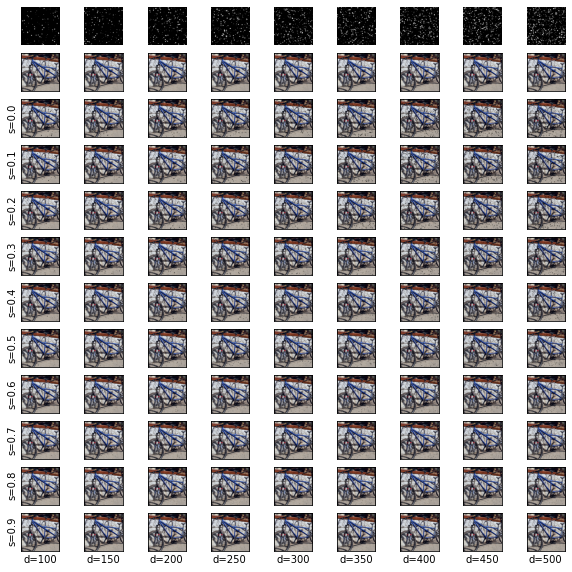

In [43]:
plt.figure(dpi=300)

x_adv = img_adv[5]
new = x_adv.cpu().detach().numpy()
plt.subplots(12,9,figsize=(10,10),sharex=True,sharey=True)
for y,i in enumerate(range(100,550,50)):
    x_temp = x_adv.unsqueeze(0)
    _,idx = fmodel(x_temp).max(axis=1)
    plt.xticks([])
    plt.yticks([])
    ax1 = plt.subplot(12,9,y+10)
#     plt.axis('off')
    plt.imshow(np.transpose(new,[1,2,0]),cmap='Greys_r')
    for strength in range(0,10,1):
        temp_row = strength
        strength /= 10
        plt.subplot(12,9,y+1,sharex=ax1)    
        x_i = get_fade_mask(i,strength)
        temp = new * x_i
        plt.axis('off')
        plt.imshow(x_i,cmap='Greys')    
        processed = torch.tensor(temp).type(torch.FloatTensor).to(device)
        _,pred = fmodel(processed.unsqueeze(0)).max(axis=1)
        temp = np.transpose(temp,[1,2,0])
#         ax = plt.subplot(3,9,y+10)
#         plt.axis('off')
#         plt.imshow(np.transpose(new,[1,2,0]),cmap='Greys_r')
    #     ax.set_xlabel(classes[idx])
        idx = y+19+temp_row*9
        ax = plt.subplot(12,9,idx,sharex=ax1)
        if ax.is_last_row():
            ax.set_xlabel(f"d={i}")
        if ax.is_first_col():
            ax.set_ylabel(f"s={strength}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(temp,cmap='Greys_r')
        
# fig.subplots_adjust(hspace=0,wspace=0)
# fig.tight_layout(h_pad=0.1)

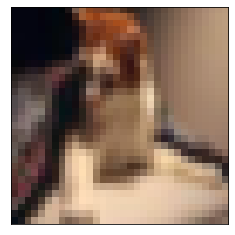

In [184]:
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(new,[1,2,0]),cmap='Greys_r')

In [68]:
#step 1 fetch adv_samples and preprocessing

mask_str = [300]
adv_vec = ''
label_list = []
for strength in mask_str:
    attack_failures=0
    recover_success=0
    is_adv=0
    for i in range(len(img_adv)):
        img = img_adv[i].unsqueeze(0)
        ori = fmodel(img)
        img = img.cpu().detach().numpy()
        ori = ori[0].cpu().detach().numpy()

        #step 2 Random Domain Fade opreation

        mask = get_fade_masks(strength,0.95)
        for i in range(try_times):
            temp = img * mask[i]
    #step 3 recover to list
            new = torch.tensor(temp).type(torch.FloatTensor).to(device)
            yhat_vec = fmodel(new)
            yhat = yhat_vec[0].cpu().detach().numpy()
            ori = np.concatenate((ori,yhat))
#         ori = ori.reshape(12,1000)
#         ori = pca.fit_transform(ori)
#         ori = ori.reshape(1,120)
        ori = ori.reshape(1,-1)
        if len(adv_vec)==0:
            adv_vec = ori
        else:
            adv_vec = np.concatenate((adv_vec,ori))
            print(adv_vec.shape)
#step 4 convert list to ndarray
adv_vec.shape

(2, 12000)
(3, 12000)
(4, 12000)
(5, 12000)
(6, 12000)
(7, 12000)
(8, 12000)
(9, 12000)
(10, 12000)
(11, 12000)
(12, 12000)
(13, 12000)
(14, 12000)
(15, 12000)
(16, 12000)
(17, 12000)
(18, 12000)
(19, 12000)
(20, 12000)
(21, 12000)
(22, 12000)
(23, 12000)
(24, 12000)
(25, 12000)
(26, 12000)
(27, 12000)
(28, 12000)
(29, 12000)
(30, 12000)
(31, 12000)
(32, 12000)
(33, 12000)
(34, 12000)
(35, 12000)
(36, 12000)
(37, 12000)
(38, 12000)
(39, 12000)
(40, 12000)
(41, 12000)
(42, 12000)
(43, 12000)
(44, 12000)
(45, 12000)
(46, 12000)
(47, 12000)
(48, 12000)
(49, 12000)
(50, 12000)
(51, 12000)
(52, 12000)
(53, 12000)
(54, 12000)
(55, 12000)
(56, 12000)
(57, 12000)
(58, 12000)
(59, 12000)
(60, 12000)
(61, 12000)
(62, 12000)
(63, 12000)
(64, 12000)
(65, 12000)
(66, 12000)
(67, 12000)
(68, 12000)
(69, 12000)
(70, 12000)
(71, 12000)
(72, 12000)
(73, 12000)
(74, 12000)
(75, 12000)
(76, 12000)
(77, 12000)
(78, 12000)
(79, 12000)
(80, 12000)
(81, 12000)
(82, 12000)
(83, 12000)
(84, 12000)
(85, 12000)


(642, 12000)
(643, 12000)
(644, 12000)
(645, 12000)
(646, 12000)
(647, 12000)
(648, 12000)
(649, 12000)
(650, 12000)
(651, 12000)
(652, 12000)
(653, 12000)
(654, 12000)
(655, 12000)
(656, 12000)
(657, 12000)
(658, 12000)
(659, 12000)
(660, 12000)
(661, 12000)
(662, 12000)
(663, 12000)
(664, 12000)
(665, 12000)
(666, 12000)
(667, 12000)
(668, 12000)
(669, 12000)
(670, 12000)
(671, 12000)
(672, 12000)
(673, 12000)
(674, 12000)
(675, 12000)
(676, 12000)
(677, 12000)
(678, 12000)
(679, 12000)
(680, 12000)
(681, 12000)
(682, 12000)
(683, 12000)
(684, 12000)
(685, 12000)
(686, 12000)
(687, 12000)
(688, 12000)
(689, 12000)
(690, 12000)
(691, 12000)
(692, 12000)
(693, 12000)
(694, 12000)
(695, 12000)
(696, 12000)
(697, 12000)
(698, 12000)
(699, 12000)
(700, 12000)
(701, 12000)
(702, 12000)
(703, 12000)
(704, 12000)
(705, 12000)
(706, 12000)
(707, 12000)
(708, 12000)
(709, 12000)
(710, 12000)
(711, 12000)
(712, 12000)
(713, 12000)
(714, 12000)
(715, 12000)
(716, 12000)
(717, 12000)
(718, 12000)

(1254, 12000)
(1255, 12000)
(1256, 12000)
(1257, 12000)
(1258, 12000)
(1259, 12000)
(1260, 12000)
(1261, 12000)
(1262, 12000)
(1263, 12000)
(1264, 12000)
(1265, 12000)
(1266, 12000)
(1267, 12000)
(1268, 12000)
(1269, 12000)
(1270, 12000)
(1271, 12000)
(1272, 12000)
(1273, 12000)
(1274, 12000)
(1275, 12000)
(1276, 12000)
(1277, 12000)
(1278, 12000)
(1279, 12000)
(1280, 12000)
(1281, 12000)
(1282, 12000)
(1283, 12000)
(1284, 12000)
(1285, 12000)
(1286, 12000)
(1287, 12000)
(1288, 12000)
(1289, 12000)
(1290, 12000)
(1291, 12000)
(1292, 12000)
(1293, 12000)
(1294, 12000)
(1295, 12000)
(1296, 12000)
(1297, 12000)
(1298, 12000)
(1299, 12000)
(1300, 12000)
(1301, 12000)
(1302, 12000)
(1303, 12000)
(1304, 12000)
(1305, 12000)
(1306, 12000)
(1307, 12000)
(1308, 12000)
(1309, 12000)
(1310, 12000)
(1311, 12000)
(1312, 12000)
(1313, 12000)
(1314, 12000)
(1315, 12000)
(1316, 12000)
(1317, 12000)
(1318, 12000)
(1319, 12000)
(1320, 12000)
(1321, 12000)
(1322, 12000)
(1323, 12000)
(1324, 12000)
(1325,

(1840, 12000)
(1841, 12000)
(1842, 12000)
(1843, 12000)
(1844, 12000)
(1845, 12000)
(1846, 12000)
(1847, 12000)
(1848, 12000)
(1849, 12000)
(1850, 12000)
(1851, 12000)
(1852, 12000)
(1853, 12000)
(1854, 12000)
(1855, 12000)
(1856, 12000)
(1857, 12000)
(1858, 12000)
(1859, 12000)
(1860, 12000)
(1861, 12000)
(1862, 12000)
(1863, 12000)
(1864, 12000)
(1865, 12000)
(1866, 12000)
(1867, 12000)
(1868, 12000)
(1869, 12000)
(1870, 12000)
(1871, 12000)
(1872, 12000)
(1873, 12000)
(1874, 12000)
(1875, 12000)
(1876, 12000)
(1877, 12000)
(1878, 12000)
(1879, 12000)
(1880, 12000)
(1881, 12000)
(1882, 12000)
(1883, 12000)
(1884, 12000)
(1885, 12000)
(1886, 12000)
(1887, 12000)
(1888, 12000)
(1889, 12000)
(1890, 12000)
(1891, 12000)
(1892, 12000)
(1893, 12000)
(1894, 12000)
(1895, 12000)
(1896, 12000)
(1897, 12000)
(1898, 12000)
(1899, 12000)
(1900, 12000)
(1901, 12000)
(1902, 12000)
(1903, 12000)
(1904, 12000)
(1905, 12000)
(1906, 12000)
(1907, 12000)
(1908, 12000)
(1909, 12000)
(1910, 12000)
(1911,

(2426, 12000)
(2427, 12000)
(2428, 12000)
(2429, 12000)
(2430, 12000)
(2431, 12000)
(2432, 12000)
(2433, 12000)
(2434, 12000)
(2435, 12000)
(2436, 12000)
(2437, 12000)
(2438, 12000)
(2439, 12000)
(2440, 12000)


(2440, 12000)

(2441, 120)

In [69]:
#Fading
#-----------
#generate benigh samples vector
ben_data = torch.load("imgNetData-ben.pkl")
ben_data = ben_data.to(device)
# ben = torch.utils.data.DataLoader(ben_data, batch_size=8, shuffle=False)

# #cifar
# tempStore = torch.empty([0, 3, 32, 32]).to(device)
# #mnist
# # tempStore = torch.empty([0, 1, 28, 28]).to(device)
# for data,lab in ben:
#     data = data.to(device)
#     tempStore = torch.cat((tempStore,data),0)
# #     print(tempStore.shape)
    
mask_str = [300]
ben_vec = ""
ben_label_list = []
for strength in mask_str:
    attack_failures=0
    recover_success=0
    is_adv=0
    for i in range(len(ben_data)):
        img = ben_data[i].unsqueeze(0)
        ori = fmodel(img)
        img = img.cpu().detach().numpy()
        ori = ori[0].cpu().detach().numpy()


        #step 2 Random Domain Fade opreation

        mask = get_fade_masks(strength,0.95)
        for i in range(try_times):
            temp = img * mask[i]
    #step 3 recover to list
            new = torch.tensor(temp).type(torch.FloatTensor).to(device)
            yhat_vec = fmodel(new)
            yhat = yhat_vec[0].cpu().detach().numpy()
            ori = np.concatenate((ori,yhat))
#         ori = ori.reshape(12,1000)
#         ori = pca.fit_transform(ori)
#         ori = ori.reshape(1,120)
        ori = ori.reshape(1,-1)
        if len(ben_vec)==0:
            ben_vec = ori
        else:
            ben_vec = np.concatenate((ben_vec,ori))

#step 4 prepare ben_vec
ben_vec.shape

(5024, 12000)

In [7]:
ben_vec= np.load('imgNet-RDF-ben-vec.npy')

In [24]:
np.save('imgNet-RDF-ben-vec',ben_vec)

In [12]:
adv_vec = pca.fit_transform(vec)

In [60]:
adv_vec.shape

(2440, 12000)

In [70]:
#Prepare dataset of detector
X_train = np.concatenate((adv_vec[:2000],ben_vec[:2000]))
y_train = np.concatenate((np.ones(2000),np.zeros(2000)))
X_test = np.concatenate((adv_vec[2000:],ben_vec[2000:2440]))
y_test = np.concatenate((np.ones(440),np.zeros(440)))

from sklearn.svm import SVC
svc_clf = SVC(kernel = 'rbf', gamma = 0.05, C = 5)
svc_clf.fit(X_train,y_train)

print(f"FPR rates:{svc_clf.score(ben_vec[4000:5000],np.zeros(1000))}")
print(f"Detection rates:{svc_clf.score(X_test,y_test)}")

FPR rates:0.965
Detection rates:0.4875


In [71]:
svc_clf.score(adv_vec[2000:2440],np.ones(440))

0.0

In [73]:
svc_clf.predict(X_test[:440])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# TODO Perturbations images of CW 